In [2]:
from tkinter import *
import PIL
from PIL import Image, ImageDraw
import os
import shutil
import numpy as np

try:
    os.mkdir('dataset')
except: #if already exist - we wish to override
    shutil.rmtree('dataset')
    os.mkdir('dataset')

def save():
    global image_number, image1, draw
    filename = f'dataset/{image_number}.png'
    image1.save(filename)
    image_number += 1
    cv.delete("all")
    image1 = Image.new('RGB', (640, 480), 'white')
    draw = ImageDraw.Draw(image1)
    
def process():
    # please don't: cv.delete("all")
    cv.delete("all")

def activate_paint(e):
    global lastx, lasty
    cv.bind('<B1-Motion>', paint)
    lastx, lasty = e.x, e.y


def paint(e):
    global lastx, lasty
    x, y = e.x, e.y
    cv.create_line((lastx, lasty, x, y), width=4)
    #  --- PIL
    draw.line((lastx, lasty, x, y), fill='black', width=4)
    lastx, lasty = x, y

def center_images():
    global image_number, image1, draw
    filename = f'dataset/{image_number}.png'
    image1.save(filename)
    for k in range(image_number+1):
        image = Image.open('dataset/'+str(k)+'.png')
        image = np.uint8(np.array(image))
        l = 0
        u = 0
        r = 640
        d = 480
        for i in range(480):
            if np.any(image[i,:,:] == 0):
                u = i
                break
        for i in range(u, 480):
            if np.all(image[i,:,:] == 255):
                d = i
                break
        for j in range(640):
            if np.any(image[:,j,:].all() == 0):
                l = j
                break
        for j in range(l, 640):
            if np.all(image[:,j,:] == 255):
                r = j
                break
        #print(l, u, r, d)
        new_image = np.uint8(np.ones((480,640,3)))*255
        
        dvert = (d-u)
        dhori = (r-l)
        
        if dvert/2 - dvert//2 == 0 and dhori/2 - dhori//2 == 0:
            new_image[240-dvert//2:240+dvert//2,
                 320-dhori//2:320+dhori//2,:] = image[u:d,l:r,:].copy()

        if dvert/2 - dvert//2 == 0 and dhori/2 - dhori//2 != 0:
            new_image[240-dvert//2:240+dvert//2,
                 320-dhori//2:320+dhori//2+1,:] = image[u:d,l:r,:].copy()
            
        if dvert/2 - dvert//2 != 0 and dhori/2 - dhori//2 == 0:
            new_image[240-dvert//2:240+dvert//2+1,
                 320-dhori//2:320+dhori//2,:] = image[u:d,l:r,:].copy()
        
        if dvert/2 - dvert//2 != 0 and dhori/2 - dhori//2 != 0:
            new_image[240-dvert//2:240+dvert//2+1,
                 320-dhori//2:320+dhori//2+1,:] = image[u:d,l:r,:].copy()
        
        
        image = Image.fromarray(new_image)
        image.save('dataset/'+str(k)+'.png')

root = Tk()
w = Label(root, text="Please draw several handwritting signatures to the database with"
          " 'save' button.\nwhen finished, sign again and type the 'process' button") 
w.pack() 
root.title('Handwritten signature veriﬁcation')
root.resizable(0, 0)


lastx, lasty = None, None
image_number = 0

cv = Canvas(root, width=640, height=480, bg='white')

# --- PIL
image1 = Image.new('RGB', (640, 480), 'white')
draw = ImageDraw.Draw(image1)

cv.bind('<1>', activate_paint)
cv.pack(expand=YES, fill=BOTH)

btn_save = Button(root, text="save", command=save)
btn_save.pack()
btn_save.place(x=250, y=480)

btn_process = Button(root, text="process", command=center_images)
btn_process.pack()
btn_process.place(x=320, y=480)

root.mainloop()

In [47]:
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from numpy import linalg as la

In [68]:
os.chdir('dataset')

In [69]:
 print(os.getcwd())

/home/matan/dataset


In [49]:
T = np.zeros((480*640, image_number - 1))
dirs = os.listdir()
k = 0
l = 0
for i in range(image_number):
    img = cv2.imread(str(i)+'.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if i < image_number - 1:
        T[:,k] = img.reshape(-1)
        k += 1
        i += 1
    else:
        test = img.reshape(-1)

#
example = T[:,2].copy()
#
    
T = np.float64(T)
Mean = np.mean(T, axis=1)
for i in range(image_number - 1):
    T[:,i] -= Mean
    

T is the matrix of preprocessed training examples,  
where each column contains one mean-subtracted image

In [50]:
test = test - Mean

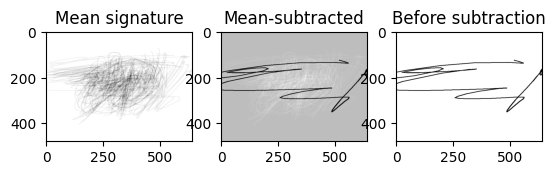

In [51]:
# only example
plt.subplot(131)
plt.imshow(Mean.reshape((480,640)), cmap = 'gray')
plt.title('Mean signature')
plt.subplot(132)
plt.imshow(T[:,2].reshape((480,640)), cmap = 'gray')
plt.title('Mean-subtracted')
plt.subplot(133)
plt.imshow(example.reshape((480,640)), cmap = 'gray')
plt.title('Before subtraction')
plt.show()

In [52]:
#  S is the covariance matrix
#S = T @ np.transpose(T)
#print (S.shape)

It's hard to compute eigenvectors of S,  
due to its dimensions. So there is a trick:

In [53]:
Temp = np.transpose(T) @ T

Now we find the eigenvectors of Temp,  
altought they aren't of the covariance matrix

In [54]:
eigval, eigvect = la.eigh(Temp)
print(eigval.shape)
print(eigvect.shape)

(47,)
(47, 47)


Thus, the covariance eigenvalues,  
also called eigenfaces : 

In [55]:
eigenfaces = np.dot(T, eigvect)
print (eigenfaces.shape)

(307200, 47)


Now, we do had to normelize those eigenvectors:  
each column is an eigenface / eigenvector

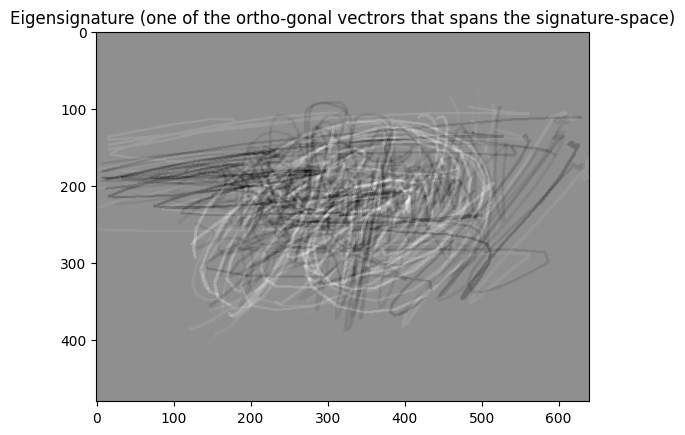

In [56]:
plt.imshow(eigenfaces[:,0].reshape((480,640)), cmap = 'gray')
plt.title('Eigensignature (one of the ortho-gonal vectrors that spans the signature-space)')
plt.show()

In [57]:
norms = la.norm(eigenfaces, axis=0)
# vector of all images' norms
print(norms.shape)

normeigenfaces = (1.0/norms)*eigenfaces
print(normeigenfaces.shape, eigenfaces.shape)

#normeigenfaces = (1.0/norms)*eigenfaces

(47,)
(307200, 47) (307200, 47)


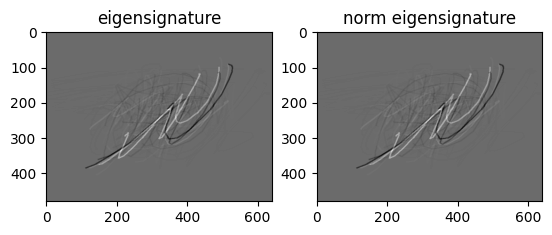

0.0 0.0


In [58]:
plt.subplot(121)
plt.imshow(eigenfaces[:,3].reshape((480,640)), cmap = 'gray')
plt.title('eigensignature')
plt.subplot(122)
plt.imshow(normeigenfaces[:,3].reshape((480,640)), cmap = 'gray')
plt.title('norm eigensignature')
plt.show()

print(eigenfaces[:,3].reshape((480,640))[0,0], normeigenfaces[:,3].reshape((480,640))[0,0])

In [59]:
eigenfaces = normeigenfaces

In [60]:
Tfeatures = np.dot(np.transpose(T), eigenfaces)
testfeature = np.dot(np.transpose(test), eigenfaces)

print (Tfeatures.shape, testfeature.shape)

(47, 47) (47,)


each image now has its own features vector,  
which is sort of an ID of the image

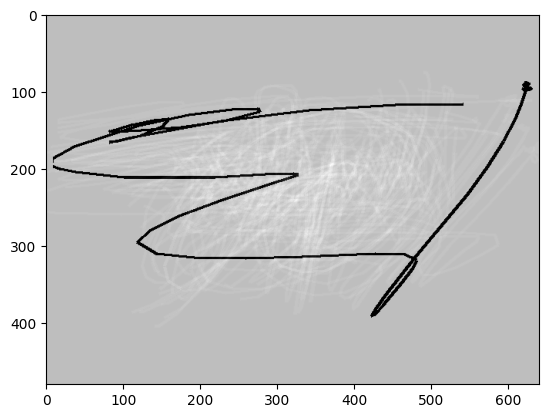

In [61]:
plt.imshow(test.reshape((480,640)), cmap = 'gray')
plt.show()

Now, let's find this face on the T matrix

In [62]:
#print(testfeature)
#print(Tfeatures[25])

[ -787.87302769  -465.39699556    65.598676     -59.90967123
   -18.7606678   -256.69317518  -265.68536442  -524.6132854
   -67.60565325   240.77662494  -263.45109052    41.57378644
    75.17914397  -174.58689743   446.99586984  -138.53025624
   219.31895882  -122.58240646   185.63151095   143.59353444
  -494.44165123    78.79900464  -124.42843742  -363.66129935
  -153.40807534   -27.11825563   -82.02809961  -463.04883271
   426.53239501   306.04596739   -43.20648058  1505.38331961
  -317.38894622   789.0883511   -523.9078299   -286.67205525
  -506.40058631  -723.24023278    44.74624874   626.64359501
    24.16502325  -748.83132414    70.87920592 -1481.05461244
  -441.18894557   582.26629866   672.03237726]
[-4.17473716e+03 -2.03754078e+02 -8.95390226e+01 -4.42577197e+00
 -1.74188884e+01  1.48651229e+02 -1.33672908e+01  6.55686708e+02
  1.69346731e+02  8.05042747e+01  3.62366182e+02 -3.11376415e+02
 -2.18869366e+02  6.23239462e+01 -1.18089554e+02  8.08665850e+02
  3.31607931e+02  6.357

In [63]:
min = la.norm(Tfeatures[0] - testfeature)
index = 0

for i in range(image_number-1):
    val = la.norm(Tfeatures[i] - testfeature)
    #print(i, " : ", val)
    if val < min:
        min = val
        index = i

0  :  22615.191626208765
1  :  23628.66799122302
2  :  24389.508530570864
3  :  25016.841881048735
4  :  21326.714268871223
5  :  25476.0941150775
6  :  21770.945451273332
7  :  20031.220873809805
8  :  21695.768742305343
9  :  21714.327484313762
10  :  19136.71210604219
11  :  19365.72923248934
12  :  18240.971094823024
13  :  15799.246894982742
14  :  19477.85249431666
15  :  19489.713358575187
16  :  16927.503484453027
17  :  17180.55206812686
18  :  19068.000303719193
19  :  18865.853904198215
20  :  20232.549488359593
21  :  18236.32830009587
22  :  13319.320269330732
23  :  13853.129160310087
24  :  16083.3142360326
25  :  15796.993007700288
26  :  15796.993007700288
27  :  16097.266984157335
28  :  15696.614550620263
29  :  17026.156849342075
30  :  15745.007562448076
31  :  15710.665411658982
32  :  13742.228455662904
33  :  13730.61470858112
34  :  14691.774841855193
35  :  12919.978065362697
36  :  12794.190758238816
37  :  24445.174435608387
38  :  20991.75086671667
39  :  2

In [64]:
print (index)

36


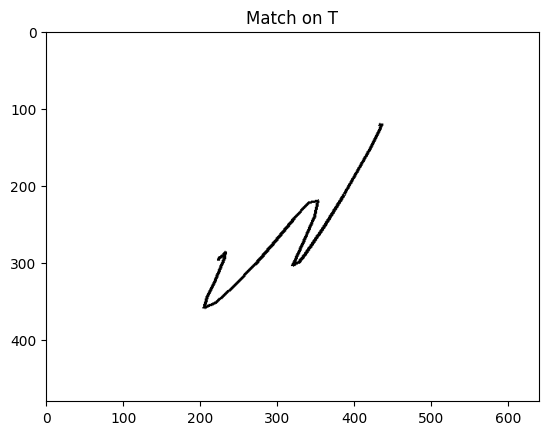

In [65]:
plt.imshow((T[:,index] + Mean).reshape((480,640)), cmap = 'gray')
plt.title('Match on T')
plt.show()